## Week 5: Find optimal bandwidth

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import expon, uniform, norm

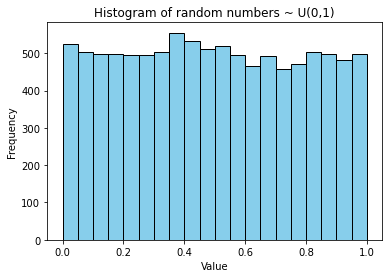

In [45]:
def generate_uniform_samples(N, m=2**32, a = 1103515245, c = 123, X = 2):
    U = []
    for i in range(N):
        X = (a*X+c)%m
        output = X/m
        U.append(output)
    return U

#main
m = 2**32  # Số nguyên lớn
a = 1103515245 # Thừa số nguyên
c = 123    # Hằng số nguyên
X = 5   # Số nguyên khởi tạo
N = 10000   # Số lượng số ngẫu nhiên cần tạo

uniform_samples = generate_uniform_samples(N)
plt.hist(uniform_samples, bins=20, color = 'skyblue', edgecolor='black')
plt.title("Histogram of random numbers ~ U(0,1)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

### Generate random numbers of Normal distribution from Uniform distribution samples

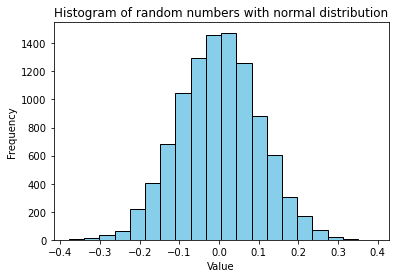

In [46]:
def box_muller_transform(u1, u2):
    z0 = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    z1 = math.sqrt(-2 * math.log(u1)) * math.sin(2 * math.pi * u2)
    return z0, z1

def generate_normal_samples(N, min_val=-1, max_val=1, mu=0, sigma=0.1):
    uniform_samples = generate_uniform_samples(N=N*2)
    normal_samples = []
    for i in range(0, len(uniform_samples), 2):
        if uniform_samples[i] == 0 or uniform_samples[i+1] == 0:
            continue
        else:
            u1, u2 = uniform_samples[i], uniform_samples[i+1] if i+1 < len(uniform_samples) else 0
            z0, z1 = box_muller_transform(u1, u2)
            normal_samples.append(z0 * sigma + mu)
    return [min(max_val, max(min_val, sample)) for sample in normal_samples]

# Determine parameters
min_val = -1
max_val = 1
mu = 0
sigma = 0.01
n = 10000

normal_numbers = generate_normal_samples(N=n)
plt.hist(normal_numbers, bins=20, color = 'skyblue', edgecolor='black')
plt.title("Histogram of random numbers with normal distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

### Kernel function

In [47]:
def kernel(u, ker_type):
    I = 0
    if abs(u) <= 1:
        I = 1
    if ker_type.lower() == 'rectangular':
        return 1/2*I
    elif ker_type.lower() == 'triangular':
        return (1-abs(u))*I
    elif ker_type.lower() == 'parabolic':
        return 3/4*(1-u*u)*I
    elif ker_type.lower() == 'biweight':
        return 15/16*(1-u*u)**2*I
    elif ker_type.lower() == 'gaussian':
        return (1 / np.sqrt(2 * np.pi)) * np.exp(-u*u / 2)
    elif ker_type.lower() == 'silverman':
        return 0.5 * np.exp(- np.abs(u) / np.sqrt(2)) * np.sin(np.abs(u) / np.sqrt(2) + np.pi / 4)
    else:
        raise Exception("Invalid kernel name")
    
ker_type = ['Rectangular', 'Triangular', 'Parabolic', 'Biweight', 'Gaussian', 'Silverman']
    

### Install the Rosenblatt estimator

In [48]:
def p_h_x(X, x, h, ker_name = ker_type[0]):
    t = 0
    for i in range(len(X)):
        t += kernel((X[i] - x) / h, ker_name)
    return t / (len(X) * h)

### Mean integrated squared error (MISE)

In [49]:
def mise(Y_kernel, Y_pdf):
    return np.mean((Y_kernel - Y_pdf) ** 2)

### Optimal bandwidth

In [50]:
def rule_of_thumb(data):
    # Calculate standard deviation
    std_dev = np.std(data)

    # Calculate interquartile range (IQR)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    iqr = Q3 - Q1
    
    # Calculate the optimal bandwidth
    h = 0.9*min(std_dev, iqr/1.34)*(len(data)**(-1/5))
    
    return h

### Apply  Parzen–Rosenblatt estimator for Uniform distribution

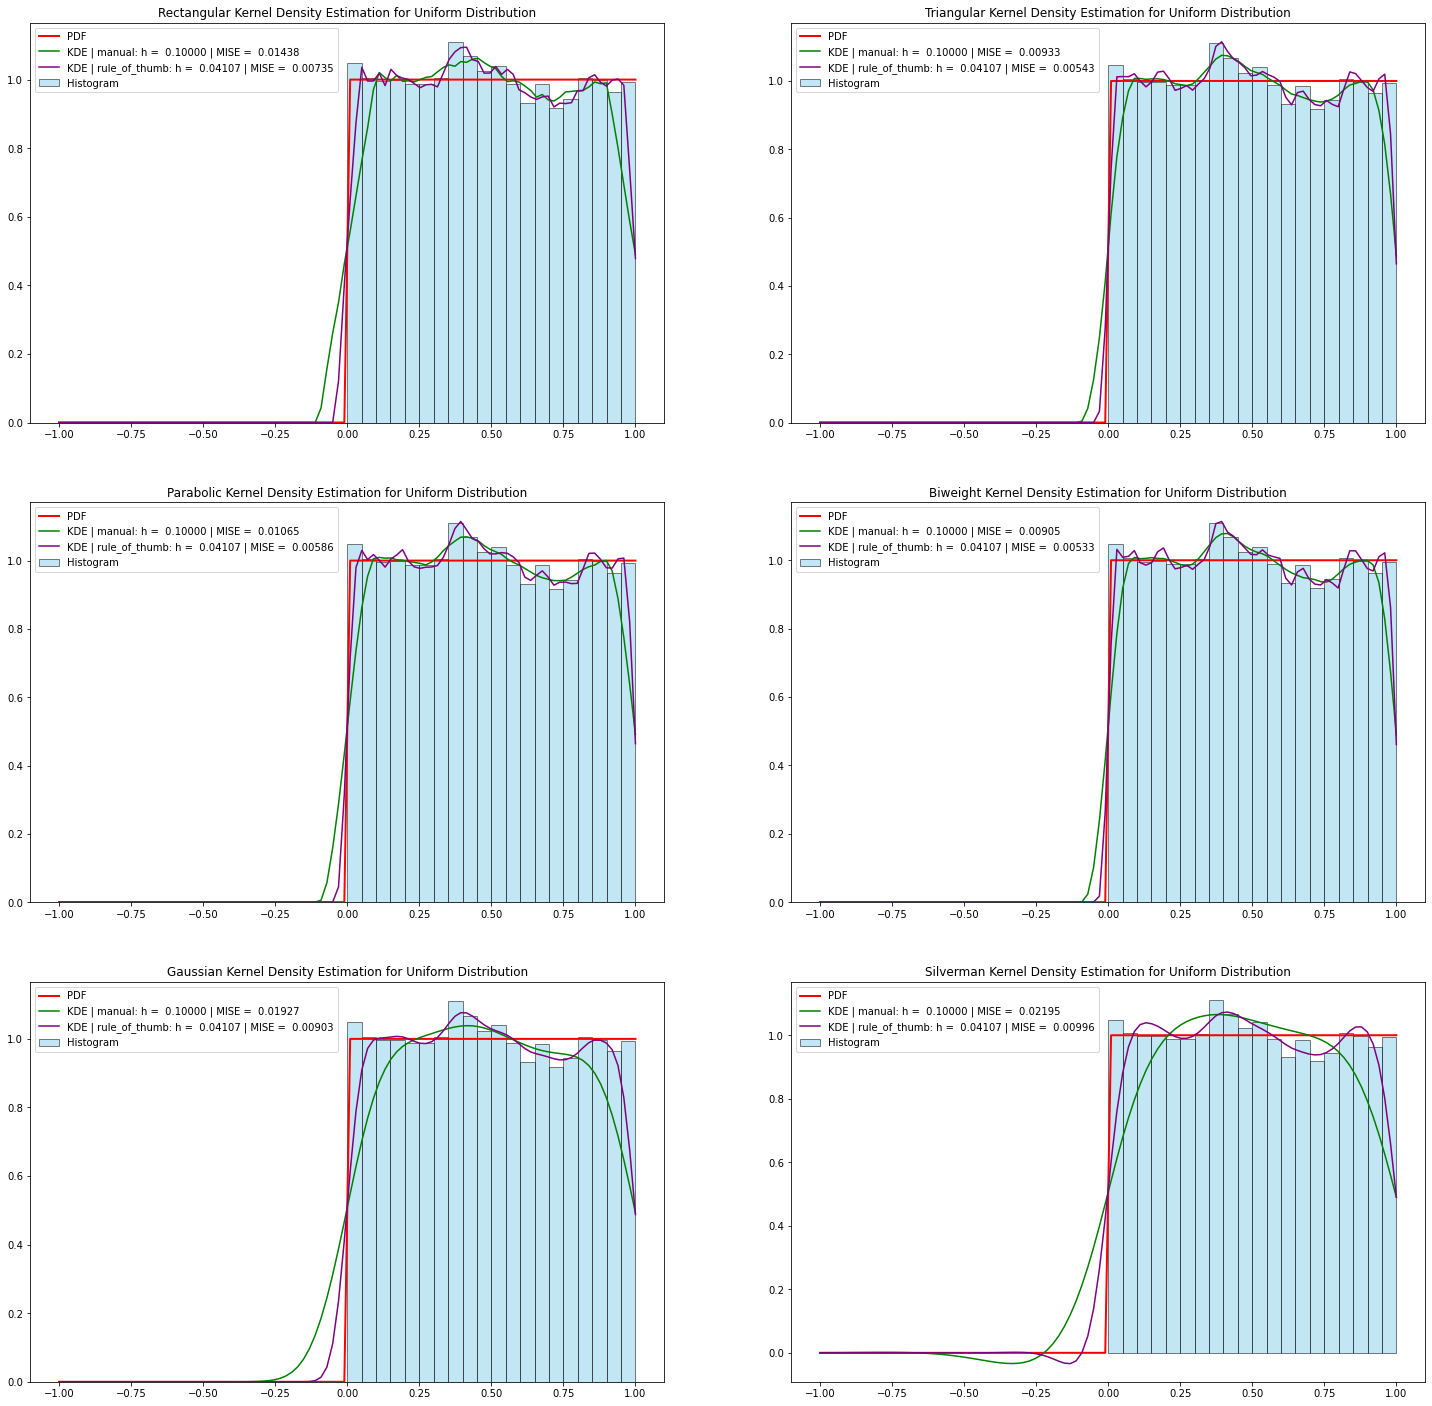

In [51]:
# Create independent identically distributed (i.i.d.) random variables Xi
N = 10000
X = generate_uniform_samples(N)

# Create input x of function p_h_x
x = np.linspace(-1, 1, 100)

# Theoretical PDF
pdf_values = uniform.pdf(x)

# Define h
h1 = 0.1 # choose h manually
h2 = rule_of_thumb(X) # choose optimal h by rule of thumb

# Function to plot KDE with different type of Kernel
def plot_kde(dist):
    plt.figure(figsize=(25, 25))
    for i in range(len(ker_type)):
        
        #Estimation of density function with different bandwidth values h
        estimation1 = [p_h_x(X, xi, h=0.1, ker_name = ker_type[i]) for xi in x]
        estimation2 = [p_h_x(X, xi, h=h2, ker_name=ker_type[i]) for xi in x]
        
        #Calculate MISE for each estimations
        mise1 = mise(estimation1, pdf_values)
        mise2 = mise(estimation2, pdf_values)
        
        #Plot the estimation of density function with different bandwidth values h
        plt.subplot(3, 2, i+1 )
        plt.title(f'{ker_type[i]} Kernel Density Estimation for {dist}')
        
        plt.hist(X, bins=20, color = 'skyblue', edgecolor='black', density=True, alpha=0.5, label='Histogram') #Histogram of X
        plt.plot(x, pdf_values , color = 'red', linewidth=2, label = 'PDF') # PDF
        plt.plot(x, estimation1, color = 'green', label = f'KDE | manual: h = {h1: .5f} | MISE = {mise1: .5f}') #KDE of manual h
        plt.plot(x, estimation2, color = 'purple', label = f'KDE | rule_of_thumb: h = {h2: .5f} | MISE = {mise2: .5f}') #KDE of optimal h
        
        plt.legend()
        
# Plot
plot_kde(dist='Uniform Distribution')
plt.show()

### Apply  Parzen–Rosenblatt estimator for Normal distribition

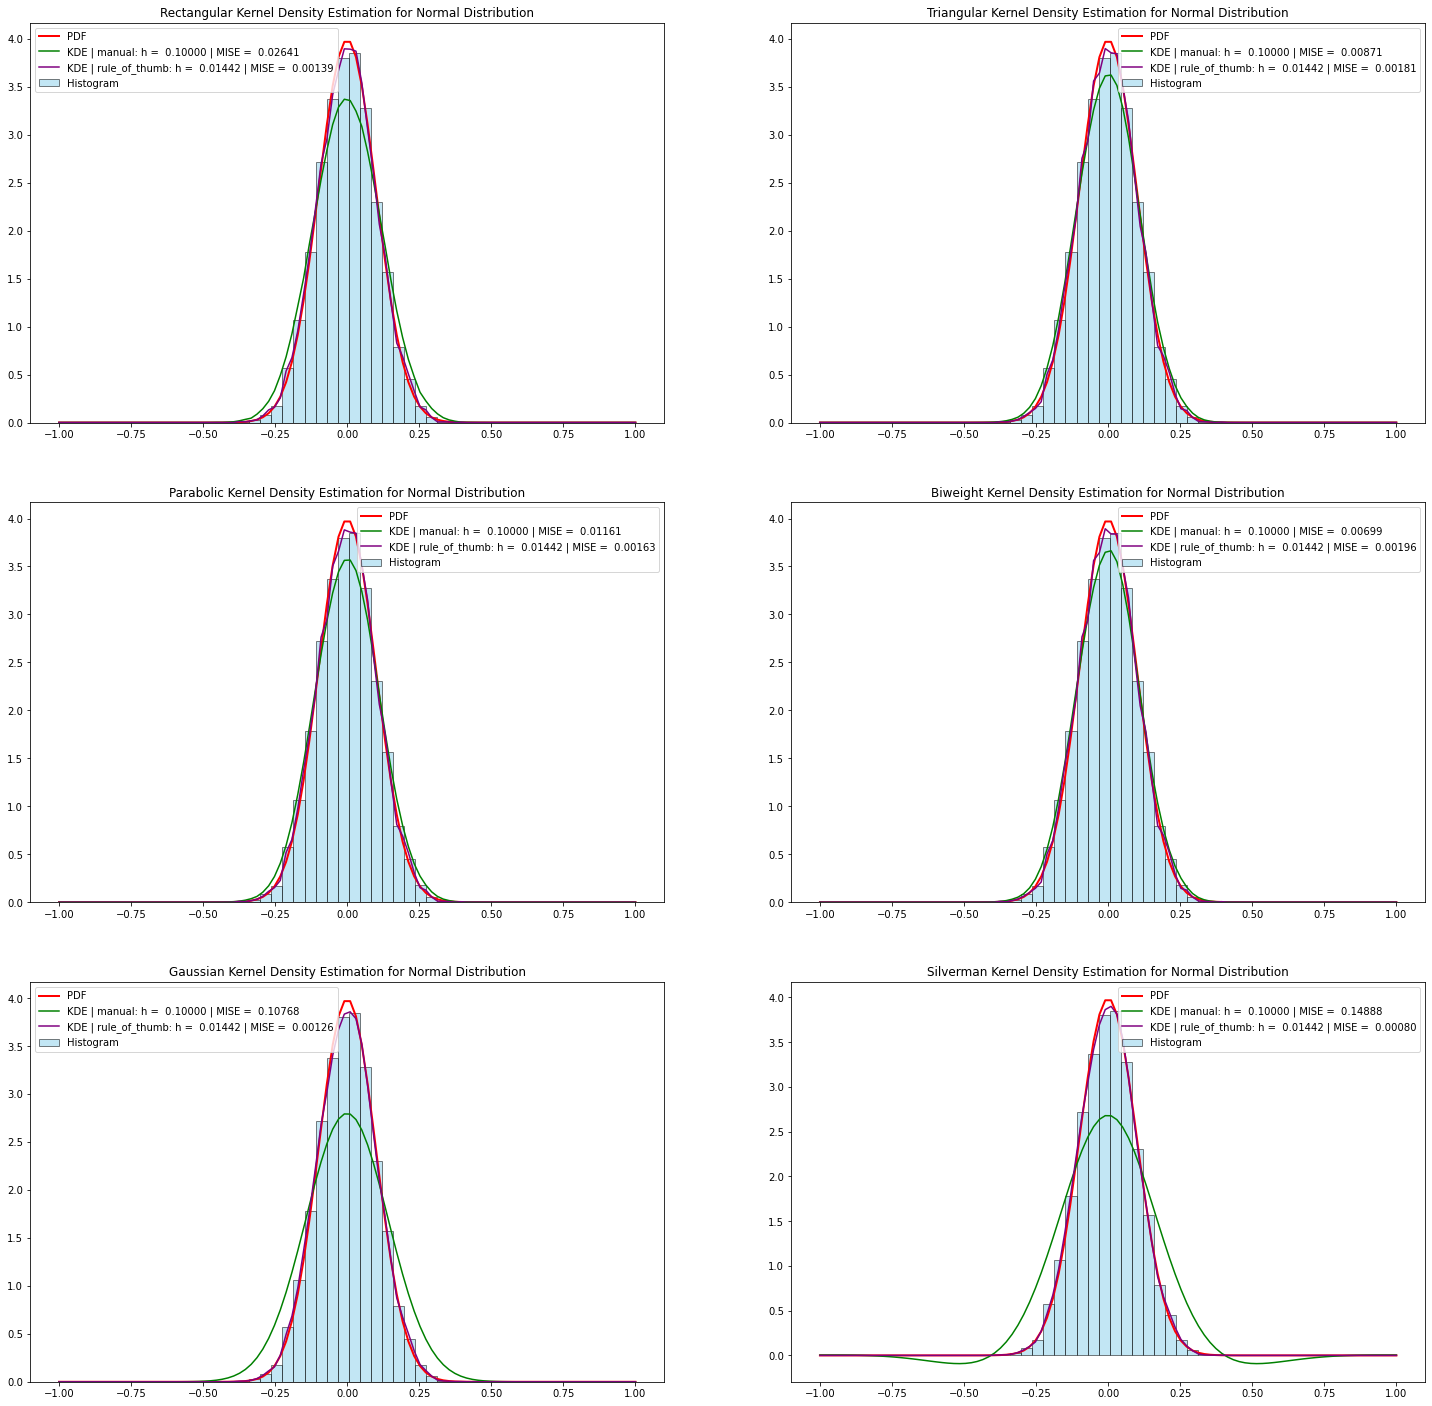

In [52]:
# Create independent identically distributed (i.i.d.) random variables Xi
N = 10000
X = generate_normal_samples(N)

# Create input x of function p_h_x
x = np.linspace(-1, 1, 100)

# Theoretical PDF
mu = 0
sigma = 0.1
pdf_values = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Define h
h1 = 0.1 # choose h manually
h2 = rule_of_thumb(X) # choose optimal h by rule of thumb

# Plot
plot_kde(dist='Normal Distribution')
plt.show()

### Apply  Parzen–Rosenblatt estimator for Exponential distribition

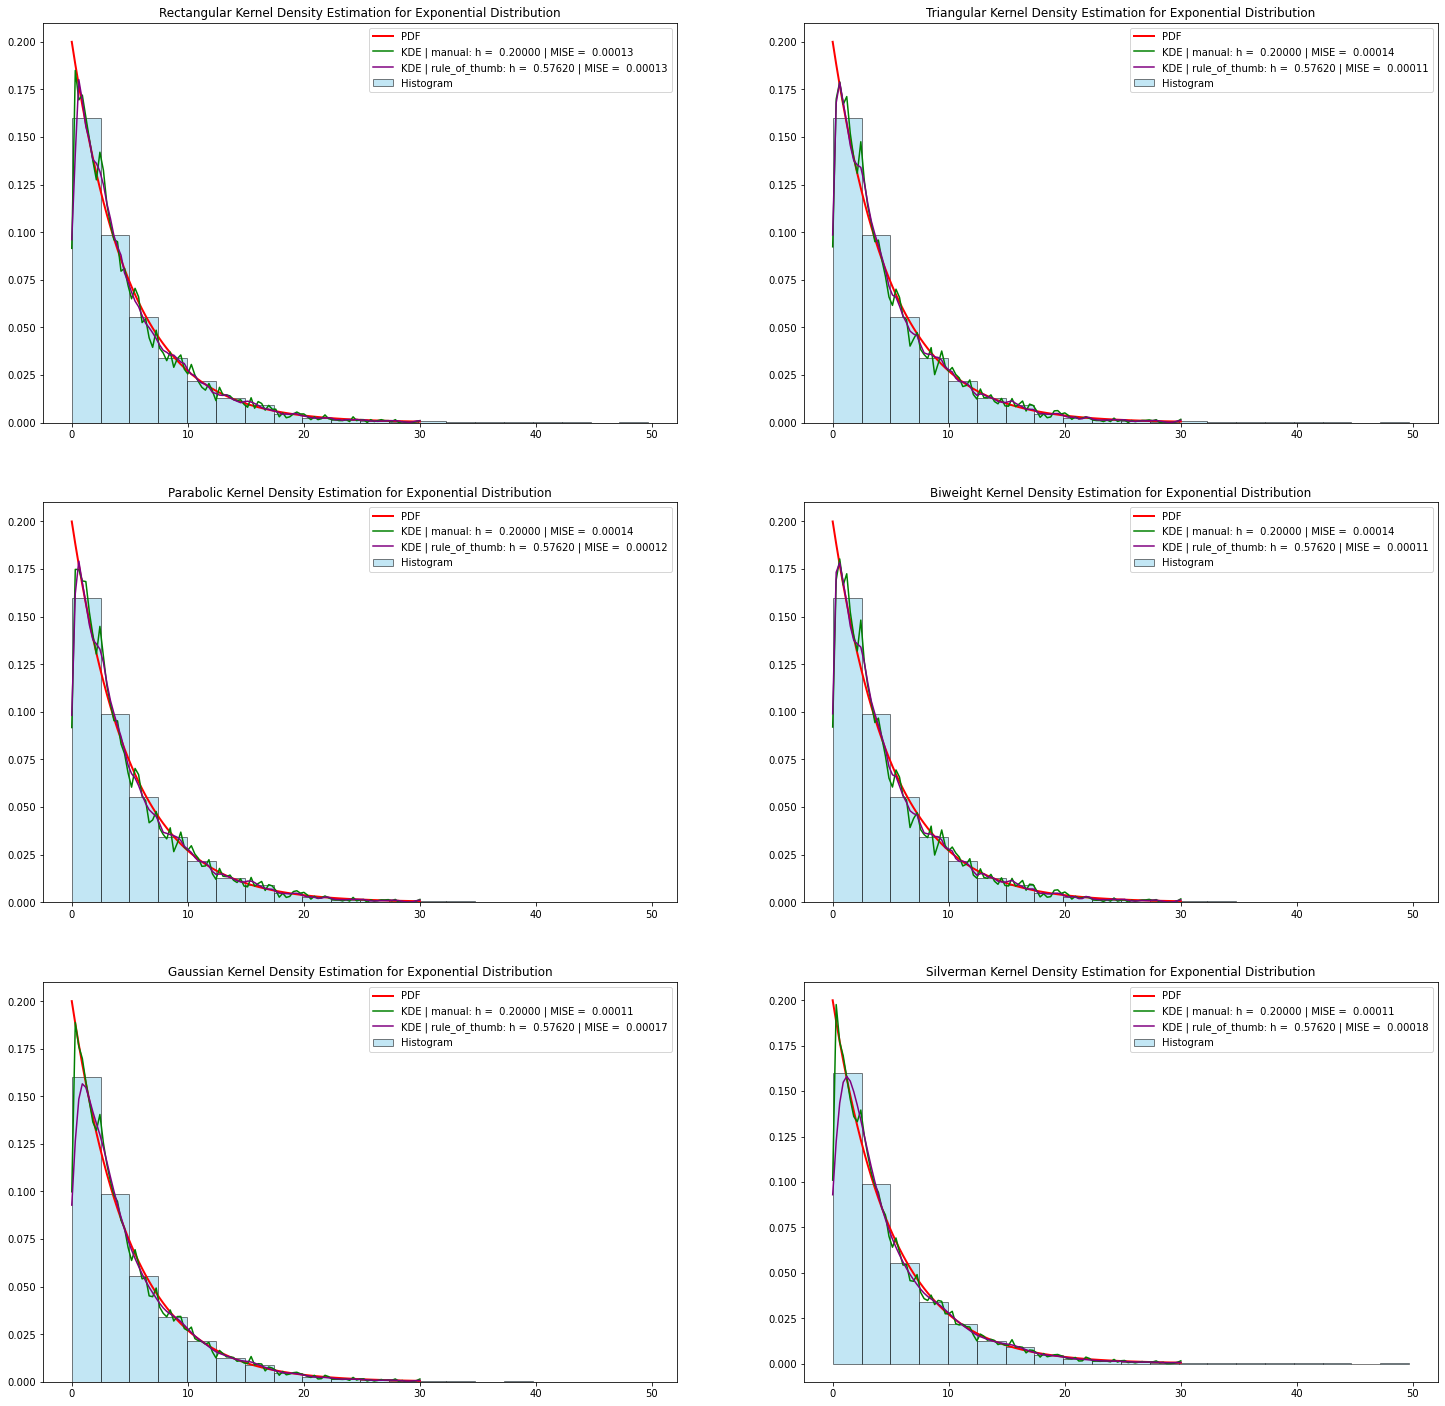

In [54]:
# Create independent identically distributed (i.i.d.) random variables Xi
def inverse_cdf_exponential(U, lamda):
    S = []
    for i in range(len(U)):
        x = np.log(1-U[i])/(-lamda)
        S = S + [x]
    return S

# define parameter
lamda  = 0.2
# generate random numbers with exponential distribution
X = inverse_cdf_exponential(uniform_samples, lamda)

# Create input x of function p_h_x
x = np.linspace(0, 30, 100)

# Theoretical PDF
pdf_values = expon.pdf(x, scale=1/lamda)

# Define h
h1 = 0.2 # choose h manually
h2 = rule_of_thumb(X) # choose optimal h by rule of thumb

# Plot
plot_kde(dist='Exponential Distribution')
plt.show()